In [1]:
# Implementation of particle swarm optimization algorithm

# importing necessary libraries

import jax
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 1200

import random
np.random.seed(69)
random.seed(69)


2023-01-27 14:30:04.053882: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 14:30:04.173878: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 14:30:04.174660: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Truss

In [2]:
# defining the geometery of truss

E = 1e7 #68947572.93178 # KN/m^2 (10e7 psi) modulus_of_elasticity
p = 0.1  #27.1447138 # KN/m^3 (0.1 lb/in^3) weight_density
s_lim = 25000 #172368.93233 #KN/m^2 (25000 psi) # allowable_stress_compression = 172368.93233 #KN/m^2 (25000 psi)
d_lim =  2 #0.0508 #m (2 inch) #displacemnt limit

In [3]:
area_avalival = [1.62, 1.80,2.38, 2.62, 2.88, 3.09, 3.13,
3.38,3.63,3.84,3.87,4.18,4.49,4.80,4.97,5.12, 5.74, 7.22,
7.97,11.5,13.5,13.9,14.2,15.5,16.0,18.8,19.9,22.0,22.9,
26.5, 30.0, 33.5]  ## sq inch

In [4]:
nodes, bars =[], []

nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2

bars.append([3,4]) #bar3
bars.append([4,5]) #bar4


bars.append([1,4]) #bar5
bars.append([2,5]) #bar6

bars.append([0,4]) #bar7
bars.append([1,3]) #bar8

bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

In [5]:
bars

array([[0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [1, 4],
       [2, 5],
       [0, 4],
       [1, 3],
       [1, 5],
       [2, 4]])

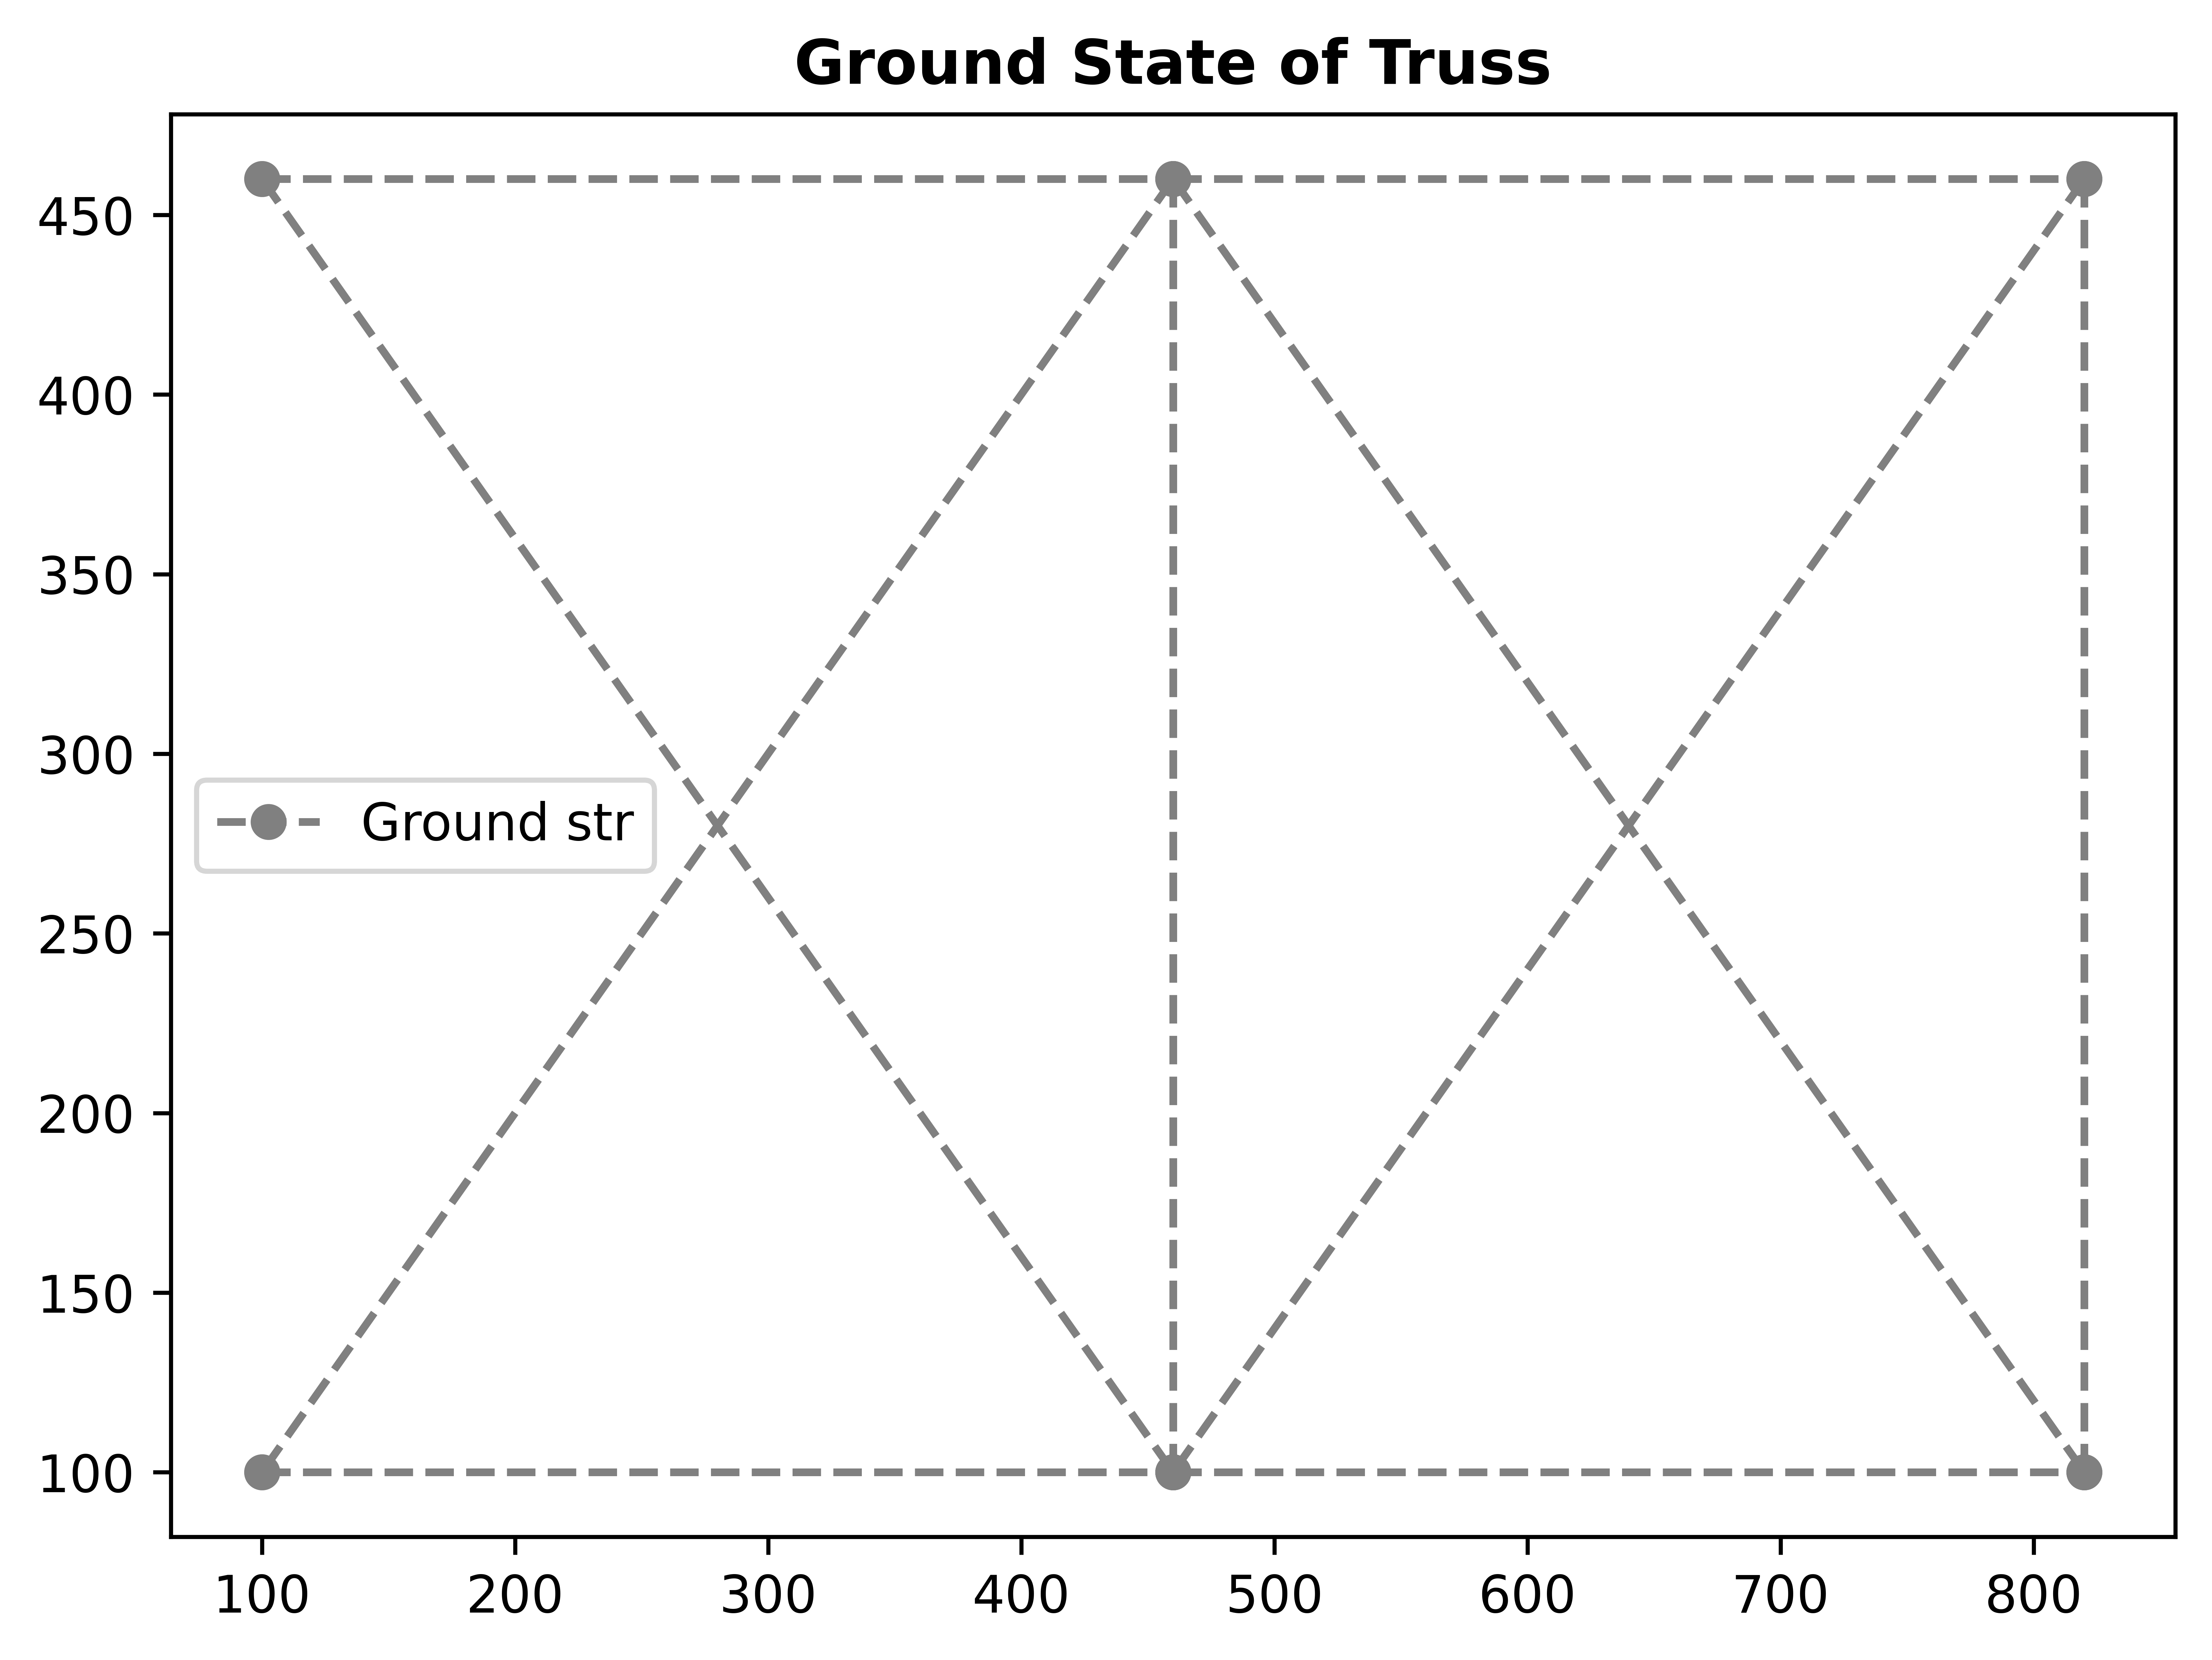

In [6]:
plt.figure(figsize=(7,5))
plt.title("Ground State of Truss", fontweight='bold')
for i in range(len(bars)):
    xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
    yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
    line, = plt.plot([xi, xf], [yi, yf], color='grey', linestyle='--', marker='o') 

line.set_label('Ground str')
plt.legend()
plt.show()

In [7]:
P = np.zeros_like(nodes) # 0 =nO LOAD # 1 == lOAD
P[4,1]= -100000
P[5,1]= -100000
print(P)

[[      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0. -100000.]
 [      0. -100000.]]


In [8]:
Ur = [0,0,0,0]

In [9]:
# Defining the degrees of Freedoms
DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[3,:] = 0
print(DOFCON)

[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [10]:
# Truss Analysis
# Doing structural analysis of the truss for an constant area of 11.5 inch^2

In [11]:
@jax.jit
class basic(): 

    def min_area(area):
        computed_area =[]
        for i in area:
            if i<1:
                computed_area.append(1)
            else:
                computed_area.append(i)
        return np.array(computed_area)

    def area_gen(area):
        area_new = []
        for i in range(10):
            area_new.append(random.choice(area))
        return area_new

    def scaler(area):
        f=[]
        a = sum(area)
        for i in area:
            i=i*50
            f.append(i/a)
        return f

    def Plot(nodes, c, lt, area, lg):
        for i in range(len(bars)):
            xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
            yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
            a = np.round(basic.scaler(area), 3)
            line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=a[i],
                             label=f'\nArea : {area[i]} in^2\n', marker='o', solid_capstyle='round') #
        line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=0.001)
        line.set_label(lg)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':4})
    

    def check( STRESS, DEFLECTION):
        x=0
        y=0
        for i in STRESS:
            if (np.abs(i) > s_lim).all():
                x +=1
                # print("Failed in Stress")
            else:
                pass
                #print("Pass in Stress")
        for i in range(6):
            ix = np.abs(DEFLECTION[i][0])
            iy = np.abs(DEFLECTION[i][1])
            if ix > d_lim:
                y+=1
                #print("Failed in Deflection along X")
            elif iy > d_lim:
                y +=1
                #print("Failed in Deflection along Y")
            else:
                pass
                #print("Pass in Deflection")
        if (x ==0) & (y==0):
            # print("Pass")
            return "Pass"
        else:
            # print(f'Failed in {x} ways for stress \n Failed in {y} ways for deflection ')
            return f'Failed in {x} ways for stress \n Failed in {y} ways for deflection '

@jax.jit
class Truss():
    # Truss Structural Analysis
    def TrussAnalysis(A, nodes, bars):
        NN = len(nodes) # number of nodes
        NE = len(bars) # number of deges
        # print(NE)

        DOF = 2 # defree of freedom
        NDOF = DOF*NN # total degree of freedom

        #structural analysis using direct stifness method

        # for bar no 3
        # takes info from node no 3 and substract it from infor of node no 2
        d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
        
        L = np.sqrt((d**2).sum(axis=1)) #leangth of the bar
        # print(f"The Leangth is {L}")
        #computing the angle 
        angle = d.T/L
        # print(f"The angle is \n\n{angle}\n\n")
        #transformation vector {a ==Transformation vector}
        a = np.concatenate((-angle.T, angle.T), axis=1)
        # print(f"The transformation vector is \n\n{a}\n\n")

        #Global stifness matrix K
        K = np.zeros([NDOF,NDOF])
        
        
        for k in range(NE):
            aux = 2*bars[k,:]
            #gives you degree of freedom in each node
            index = np.r_[aux[0]:aux[0]+2, aux[1]:aux[1]+2]
            # print(f'a : {a.shape}, A: {A.shape}, L: {L.shape}')
            ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
            # print(f"Stifness Matrix \n\n{ES}\n\n")
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES

        freeDOF = DOFCON.flatten().nonzero()[0]
        supportDOF = (DOFCON.flatten()==0).nonzero()[0]

        Kff = K[np.ix_(freeDOF, freeDOF)]
        Kfr = K[np.ix_(freeDOF, supportDOF)]
        Krf = Kfr.T
        # print(f'{Kfr}, \n \n {Kff}, \n \n {Krf}')
        Krr = K[np.ix_(supportDOF, supportDOF)]
        
        Pf = P.flatten()[freeDOF]
        #Uf = np.linalg.solve(Kff, Pf) #.lstsq
        Uf = np.linalg.inv(Kff)@ Pf
        U  = DOFCON.astype(float).flatten()
        U[freeDOF] = Uf
        U[supportDOF] = Ur

        U = U.reshape(NN, DOF) #displacement of the truss members
        u = np.concatenate((U[bars[:,0]], U[bars[:,1]]), axis=1)
        # print(E)
        # print(A)
        N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
        R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
        R = R.reshape(2,DOF)

        # Stress
        S = N/A

        #weight of str
        Volume = (1*A*L).sum() #for mass replace 1 by p

        #check
        c = basic.check(S, U)

        return S, Volume, U, c, R

basic = jax.jit(basic)
Truss = jax.jit(Truss)

In [12]:
x = np.array([20 for i in range(10)]).astype(float)
x

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [13]:
Truss.TrussAnalysis(x, nodes, bars)

(array([  9768.24934844,   2006.23161277, -10231.75065156,  -2993.76838723,
          1774.48096122,   2006.23161277,   7398.81272639,  -6743.32289734,
          4233.82785582,  -2837.23995605]),
 83929.35059634515,
 array([[ 0.        ,  0.        ],
        [ 0.35165698, -0.83717623],
        [ 0.42388131, -1.89756315],
        [ 0.        ,  0.        ],
        [-0.36834302, -0.90105754],
        [-0.47611869, -1.96978749]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

In [14]:
###

In [15]:
# # Applying force over the structure
# P = np.zeros_like(nodes)
# P[5,1] = -10

# # Support displacement 
# Ur = [0,0,0,0]

# # Degrees of Freedom (1=free, 0=fixed)
# dof = np.ones_like(nodes).astype(int)
# dof[0,:] = 0
# dof[4,:] = 0

# # area
# Ai = [0.111, 0.141, 0.174, 0.220, 0.270, 0.287, 0.347, 0.448, 0.539, 0.954,
# 1.081, 1.174, 1.333, 1.488, 1.764, 2.142, 2.697, 2.800, 3.131, 3.565,
# 3.813, 4.805, 5.952, 6.572, 7.192, 8.525, 9.300, 10.850, 13.330, 14.290,
# 17.178, 19.188]

# A_index = np.linspace(0, len(Ai)-1, len(Ai)).astype(int)

# # Node Condition of Movement

# # NC =[]
# # # for i in range(8):
# # NC.append([100,140])
# # NC.append([220,260])
# # NC.append([100,140])
# # NC.append([100,140])
# # NC.append([50,90])
# # NC.append([-20,20])
# # NC.append([-20,20])
# # NC.append([20,60])
# # NC = np.array(NC)

# NC = nodes

In [16]:
# def AssignGeometry(var, d, d1):
#     NCi = var[d1:d] #Node Connections

#     # Assign geometry variables 
#     nodes[1,0] = NCi[0]
#     nodes[5,0] = NCi[0]
#     nodes[2,0] = NCi[1]
#     nodes[6,0] = NCi[1]
#     nodes[1,1] = NCi[2]
#     nodes[2,1] = NCi[3]
#     nodes[3,1] = NCi[4]
#     nodes[5,1] = NCi[5]
#     # nodes[6,1] = NCi[6]
#     # nodes[7,1] = NCi[7]

In [17]:
# #Problem Defination for Particle Swarm
# d1 = len(bars)
# d2 = len(NC)
# d = d1+d2

# #lower and upper bound for area
# Xlim = [min(A_index), max(A_index)]*np.ones([len(bars),2])
# Xlim = np.concatenate([Xlim, NC], axis=0)

# #Lower and upper bound of velocity
# Vlim = np.zeros([d,2])
# Vlim[:,1] = (Xlim[:,1] - Xlim[:,0])*0.2
# Vlim[:,0] = -Vlim[:,1]

# MaxIt = 500 # max value of iter
# ps = 9 #total pop
# c1 = 2 
# c2 = 2
# w = 0.9-((0.9-0.4)/MaxIt )*np.linspace(0, MaxIt , MaxIt)

# def limitv(V, d):
#     for j in range(d):
#         if V[j]  > Vlim[j,1]:
#             V[j] = Vlim[j,1]
#         if V[j] < Vlim[j,0]:
#             V[j]= Vlim[j,0]
#     return V

# def Plot(nodes, X, D, D1, Assign, c, lt, lw, lg):
#     if Assign == 1:
#         AssignGeometry(X, D, D1)
#     for i in range(D1):
#         xi, xf = nodes[bars [1,0],0], nodes[bars [1,1],0]
#         yi, yf= nodes[bars [1,0],0], nodes[bars [1,1],1]
#         line, = plt.plot([xi, xf],[yi, yf],color=c, linestyle=lt, linewidth=lw)
#     line.set_label(lg)
#     plt.legend (prop={'size' : 8})

# def FindNearest(array, value):
#     array = np.asarray (array)
#     idx = np.abs(array - value).argmin()
#     #idx = np.argmin(array)
#     return array[idx]


In [18]:
# # ALBortnm
# def opt():
#     class Particle():
#         def __init__(self):
#             self.position = np.zeros([ps,d])
#             self.velocity = np.zeros([ps,d])
#             self.cost = np.zeros(ps)
#             self.stress= np.zeros([ps, d1])
#             for i in range(ps):
#                 for j in range(d):
#                     if j < d1:
#                         self.position[i,j] = np.random.choice(A_index[A_index >15])
#                     else:
#                         self.position[i,j] = np.random.uniform(Xlim[j,0],Vlim[j,1])
#                     self.velocity[i,j] = np.random.uniform(Vlim[j,0], Vlim[j,1])
#                 self.stress[i],self.cost[i]=Truss.TrussAnalysis(self.position[i],d,d1)
#             self.pbest = np.copy(self.position)
#             self.pbest_cost = np.copy(self.cost)
#             self.index = np.argmin(self.pbest_cost)
#             self.gbest = self.pbest[self. index]
#             self.gbest_cost= self.pbest_cost[self. index]
#             self.BestCost = np.zeros(MaxIt)
#             self.BestPosition = np.zeros([MaxIt, d])


#         def Evaluate(self):
#             for it in range(MaxIt):
#                 for i in range(ps):
#                     self.velocity[i] = (w[it]*self.velocity[i] + c1*np.random.rand(d)*(self.pbest[i] - self.position[i]) +c2*np.random.rand(d)*(self.gbest - self.position[i]))
                    
#                     self.velocity[i] = limitv(self.velocity[i],d)
#                     self.position[i] = self.position [i] + self.velocity[i]

#                     for p in range(d1):
#                         self.position[i, p] = FindNearest(A_index, self.position[i,p])
#                     self.stress[i], self.cost[i] = Truss.TrussAnalysis(self.position[i], d,d1)
                    
#                     C_total = 0
#                     for cd in range(d1):
#                         if np.abs(self.stress[i, cd]) > s_lim :
#                             C1 = np.abs((self.stress[i,cd]-s_lim)/s_lim)
#                         else:
#                             C1=0
#                         C_total = C_total +C1
#                     phi = (1+C_total)
#                     self.cost[i]=self.cost[i]*phi
#                     if self.cost[i] < self.pbest_cost[i]:
#                         self.pbest[i] = self.position[i]
#                         self.pbest_cost[i] = self.cost[i]
#                         if self.pbest_cost[i] < self.gbest_cost:
#                             self.gbest = self.pbest[i]
#                             self.gbest_cost = self.pbest_cost[i]
#                 self.BestCost[it] = self.gbest_cost
#                 self.BestPosition[it] = self.gbest

#         def Plot(self):
#             np.set_printoptions(precision=6, suppress=True)
#             plt.figure(0)

#             plt.plot(self.BestCost)
#             print('Design Variables')
#             Design_var = np.copy(self.position[-1])
#             for i in range(d1):
#                 Design_var[i] = Ai[self.position[-1, i].astype(int)]
#             print(Design_var[np.newaxis].T)
#             Stress, Cost = Truss.TrussAnalysis(self.BestPosition[-1],d, d1)
#             print(f'Stress [ksi]')
#             print(Stress[np.newaxis ].T)
#             print("Best fitness value =", self.gbest_cost)
#             # plt.figure(1)
#             # Plot(original_nodes, Design_var, d, d1,0, 'gray','--',1, 'Original design')
#             # Plot(nodes, Design_var, d, d1, 1, 'red', '-',1, 'Optimal design')

#         def Plot1(nodes, c, lt, lw, lg):
#             for i in range(len(bars)):
#                 xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
#                 yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
#                 line, = plt. plot([xi, xf], [yi, yf], color=c, linestyle=lt, linewidth=lw)
#             line.set_label(lg)
#             plt.figure(1)
#         Plot1(original_nodes, c='gray',lt='--',lw=1, lg='Original design')
#         Plot1(nodes,c='red', lt='-',lw=1, lg='Optimal design')

#     a = Particle()
#     a.Evaluate()
#     a.Plot()
#     # # a.Plot1()
#     # a.Plot1(original_nodes, c='gray',lt='--',lw=1, lg='Original design')
#     # a.Plot1(nodes,c='red', lt='-',lw=1, lg='Optimal design')

In [19]:
# opt()

# Particle Swarm Optimization

In [20]:
# from pyswarms.single.global_best import GlobalBestPSO
# from pyswarms.utils.functions import single_obj as fx

# # Define the truss structure and objective function
# def evaluate_truss(individual):

#     ans = Truss.TrussAnalysis(individual, nodes, bars)
#     if ans[3] == "Pass":
#         return ans[1]
#     else:
#         return -ans[1]

# # Define your bounds
# bounds = [(1,10),]

# # Initialize swarm
# optimizer = GlobalBestPSO(n_particles=10, dimensions=1, options={'c1': 0.5, 'c2': 0.5,'w': 0.9}, )

# # Optimize
# best_pos, best_fit = optimizer.optimize(evaluate_truss, iters=100)

# # Print the results
# print("Best position: ", best_pos)
# print("Best fitness: ", best_fit)

In [21]:
# type(best_pos)

In [22]:
# from pyswarms.single.global_best import GlobalBestPSO

# # Define the truss structure and objective function
# def evaluate_truss(individual):
#     ans = Truss.TrussAnalysis(individual, nodes, bars)
#     if ans[3] == "Pass":
#         return ans[1]
#     else:
#         return 9999999

# # Define your bounds
# bounds = [(1,10),]

# # Initialize swarm
# optimizer = GlobalBestPSO(n_particles=10, dimensions=1, options={'c1': 0.5, 'c2': 0.5,'w': 0.9}, bounds=bounds)

# # Optimize
# best_pos, best_fit = optimizer.optimize(evaluate_truss, iters=100)

# # Print the results
# print("Best position: ", best_pos)
# print("Best fitness: ", best_fit)


# 1

In [23]:
# # Objective function to optimize
# def obj_func(x):
#     return (2*x**2 + 5)**2

# # PSO algorithm
# def pso(obj_func, bounds, num_particles, num_iterations):
#     # Initialize position and velocity of each particle with a random x value
#     pos = np.random.uniform(bounds[0], bounds[1], (num_particles, 1))
#     vel = np.random.uniform(-1, 1, (num_particles, 1))
#     # Initialize personal and global best positions
#     pbest_pos = pos.copy()
#     gbest_pos = pos[np.argmin([obj_func(p) for p in pos])]
#     # Set constants for PSO algorithm
#     w = 0.7
#     c1 = 2
#     c2 = 2
#     # Iterate for a set number of iterations
#     for i in range(num_iterations):
#         # Update velocity and position of each particle
#         for j in range(num_particles):
#             vel[j] = w*vel[j] + c1*np.random.random()*(pbest_pos[j]-pos[j]) + c2*np.random.random()*(gbest_pos-pos[j])
#             pos[j] = pos[j] + vel[j]
#             # Check if new position is personal best
#             if obj_func(pos[j]) < obj_func(pbest_pos[j]):
#                 pbest_pos[j] = pos[j]
#             # Check if new position is global best
#             if obj_func(pos[j]) < obj_func(gbest_pos):
#                 gbest_pos = pos[j]
#     return gbest_pos[0]

# # Set bounds for x
# bounds = [-10, 10]
# # Set number of particles and iterations
# num_particles = 10
# num_iterations = 100
# # Run PSO
# result = pso(obj_func, bounds, num_particles, num_iterations)
# print("Optimal value of x: ", result)
# print("Optimal value of y: ", obj_func(result))

In [24]:
# obj_func(0.011)

In [25]:
import random
import numpy as np

def optimize(f, num_particles, num_iterations):
    # Define the optimization function
    def fitness(x):
        return f(x)
    # Initialize the particle positions and velocities
    particles = [np.array([random.uniform(-10, 10) for _ in range(1)]) for _ in range(num_particles)]
    velocities = [np.array([random.uniform(-1, 1) for _ in range(1)]) for _ in range(num_particles)]
    # Initialize the best positions and values for each particle
    pbest_positions = particles[:]
    pbest_values = [fitness(p) for p in particles]
    # Initialize the global best position and value
    gbest_position = np.array([random.uniform(-10, 10) for _ in range(1)])
    gbest_value = fitness(gbest_position)
    # Define the PSO parameters
    w = 0.7
    c1 = 1.5
    c2 = 2.0
    # Perform the PSO optimization
    for i in range(num_iterations):
        for j, particle in enumerate(particles):
            # Update the particle velocity
            velocities[j] = w * velocities[j] + c1 * random.random() * (pbest_positions[j] - particle) + c2 * random.random() * (gbest_position - particle)
            # Update the particle position
            particles[j] = particle + velocities[j]
            # Update the personal best position and value for this particle
            if fitness(particles[j]) < pbest_values[j]:
                pbest_positions[j] = particles[j]
                pbest_values[j] = fitness(particles[j])
                # Update the global best position and value if necessary
                if pbest_values[j] < gbest_value:
                    gbest_position = pbest_positions[j]
                    gbest_value = pbest_values[j]
    # Return the global best position and value
    return gbest_position, gbest_value

# Define the function to be optimized
def f(x):
    return (2*x - 5)**2

# Optimize the function using PSO
num_particles = 20
num_iterations = 1000
gbest_position, gbest_value = optimize(f, num_particles, num_iterations)
print("Global best position:", gbest_position)
print("Global best value:", gbest_value)


Global best position: [2.5]
Global best value: [0.]


In [29]:
import random
import numpy as np

def optimize(f, num_particles, num_iterations):
    # Define the optimization function
    # x = np.random.rand(10)
    def fitness(x):
        return f(x)
    # Initialize the particle positions and velocities
    particles = [np.array([random.uniform(-10, 10) for _ in range(1)]) for _ in range(num_particles)]
    velocities = [np.array([random.uniform(-1, 1) for _ in range(1)]) for _ in range(num_particles)]
    # Initialize the best positions and values for each particle
    pbest_positions = particles[:]
    pbest_values = [fitness(np.array([p]*10)) for p in particles]
    # Initialize the global best position and value
    gbest_position = np.array([random.uniform(1, 32) for _ in range(10)])
    # print(gbest_position)
    gbest_value = fitness(gbest_position)
    # Define the PSO parameters
    w = 0.7
    c1 = 1.5
    c2 = 2.0
    # Perform the PSO optimization
    for i in range(num_iterations):
        for j, particle in enumerate(particles):
            # Update the particle velocity
            velocities[j] = w * velocities[j] + c1 * random.random() * (pbest_positions[j] - particle) + c2 * random.random() * (gbest_position - particle)
            # Update the particle position
            particles[j] = particle + velocities[j]
            # Update the personal best position and value for this particle
            if fitness(particles[j]) < pbest_values[j]:
                pbest_positions[j] = particles[j]
                pbest_values[j] = fitness(particles[j])
                # Update the global best position and value if necessary
                if pbest_values[j] < gbest_value:
                    gbest_position = pbest_positions[j]
                    gbest_value = pbest_values[j]
    # Return the global best position and value
    return gbest_position, gbest_value

# Define the function to be optimized
def f(x):
    # print(x)
    ans = Truss.TrussAnalysis(x, nodes, bars)
    if (x > 0).all() and ans[3]=="Pass":
        return ans[1]
    else: return 99999999

# Optimize the function using PSO
num_particles = 20
num_iterations = 1000
gbest_position, gbest_value = optimize(f, num_particles, num_iterations)
print("Global best position:", gbest_position)
print("Global best value:", gbest_value)


Global best position: [21.93527446 15.8168264  17.72771914 18.29038938 15.54741074 20.705112
 19.87435339 18.1317291  23.48458124 21.4470163 ]
Global best value: 81833.1566567243
